In [2]:
from ds_utils.ds_preamble import *
from ds_utils.ds_helper import *
from ds_utils.ds_plotting import *
import duckdb

# from ds_utils.ds_preamble import *  # # self-defined module
# from ds_utils.ds_helper import *  # self-defined module
# from ds_utils.ds_plotting import *  # # self-defined module

# import datetime
# import duckdb
# import pathlib

tips = sns.load_dataset('tips')
tips_tiny = tips.sample(20)
from glob import glob
import re

np.random.seed(123)
tips['decile'] = np.random.randint(1,4, size=len(tips))

train = tips.sample(frac=0.7, random_state=30).reset_index(drop=True)
test = tips.drop(train.index).reset_index(drop=True)

# paths = ["/Users/whlin/Library/CloudStorage/OneDrive-HKUSTConnect/Documents/python/code_from_others/pydata-book-3rd-edition/datasets/movielens"]

# for path in paths:
#     if path not in sys.path:
#         sys.path.append(path)
        
        

calling ds_preamble..
calling ds_helper...


In [2]:
path = "/Users/whlin/Library/CloudStorage/OneDrive-HKUSTConnect/Documents/python/code_from_others/pydata-book-3rd-edition/datasets/movielens"
# Make display smaller
pd.options.display.max_rows = 10

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table(Path(path, 'users.dat'), sep='::',
                      header=None, names=unames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(Path(path, 'ratings.dat'), sep='::',
                        header=None, names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table(Path(path, 'movies.dat'), sep='::',
                       header=None, names=mnames)

for df in [users, ratings, movies]:
    df.shape

df = pd.merge(pd.merge(ratings, users), movies)

/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_15537/4253065332.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_table(Path(path, 'users.dat'), sep='::',
/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_15537/4253065332.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_table(Path(path, 'ratings.dat'), sep='::',
/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_15537/4253065332.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+

(6040, 5)

(1000209, 4)

(3883, 3)

## rating count problems

### show only those records with mean rating < 3

In [3]:
# M1: bad 
useful_idx = df.groupby('movie_id').rating.mean().lt(3)[lambda x: x].index
df.query("movie_id in @useful_idx")


# M2: not as bad 
df.assign(avg=df.groupby('movie_id').rating.transform('mean')).query("avg < 3")[:2]

# M3: use boolean filtering
df[df.groupby('movie_id').rating.transform('mean').lt(3)][:2]

# M4: good
(
df
.groupby('movie_id')
.filter(lambda g: g.rating.mean() < 3) # find those mean rating < 3
)[:2]

q = """
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id))
SELECT * FROM df WHERE movie_id IN (SELECT movie_id FROM df GROUP BY movie_id HAVING avg(rating)<3)
"""

q = """
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),
df_avg AS (SELECT *, avg(rating) OVER (PARTITION BY movie_id) FROM df)
SELECT *, count(*) over() FROM df_avg WHERE avg < 3
"""

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
28501,1,48,5,978824351,F,1,10,48067,Pocahontas (1995),Animation|Children's|Musical|Romance
28502,6,48,5,978237570,F,50,9,55117,Pocahontas (1995),Animation|Children's|Musical|Romance
28503,10,48,4,978230090,F,35,1,95370,Pocahontas (1995),Animation|Children's|Musical|Romance
28504,18,48,4,978155072,F,18,3,95825,Pocahontas (1995),Animation|Children's|Musical|Romance
28505,26,48,3,978141288,M,25,7,23112,Pocahontas (1995),Animation|Children's|Musical|Romance
...,...,...,...,...,...,...,...,...,...,...
1000186,5944,1868,1,957197520,F,18,10,27606,"Truce, The (1996)",Drama|War
1000193,5227,591,3,961475931,M,18,10,64050,Tough and Deadly (1995),Action|Drama|Thriller
1000194,5795,591,1,958145253,M,25,1,92688,Tough and Deadly (1995),Action|Drama|Thriller
1000198,5334,127,1,960795494,F,56,13,46140,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,avg
28501,1,48,5,978824351,F,1,10,48067,Pocahontas (1995),Animation|Children's|Musical|Romance,2.97644
28502,6,48,5,978237570,F,50,9,55117,Pocahontas (1995),Animation|Children's|Musical|Romance,2.97644


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
28501,1,48,5,978824351,F,1,10,48067,Pocahontas (1995),Animation|Children's|Musical|Romance
28502,6,48,5,978237570,F,50,9,55117,Pocahontas (1995),Animation|Children's|Musical|Romance


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
28501,1,48,5,978824351,F,1,10,48067,Pocahontas (1995),Animation|Children's|Musical|Romance
28502,6,48,5,978237570,F,50,9,55117,Pocahontas (1995),Animation|Children's|Musical|Romance


### find the ratings count for each movie, having counts > 250 

In [4]:
# M1
(
pd.merge(ratings, movies) # from
.title # 
.value_counts()[lambda x: x>250]
.sort_values(ascending=False)
)

# M2
(
pd
.merge(ratings, movies) # from 
.groupby('title') 
.filter(lambda g: len(g)>250) # having 
.groupby('title') 
.size() # select 
.sort_values(ascending=False) # order by 
)

q = """
SELECT title, count(*) FROM ratings r, movies m WHERE r.movie_id = m.movie_id  GROUP BY title HAVING count(*) > 250 ORDER BY count(*) DESC
"""
# print(duckdb.query(q).df()[:5])

American Beauty (1999)                                            3428
Star Wars: Episode IV - A New Hope (1977)                         2991
Star Wars: Episode V - The Empire Strikes Back (1980)             2990
Star Wars: Episode VI - Return of the Jedi (1983)                 2883
Jurassic Park (1993)                                              2672
                                                                  ... 
Bachelor, The (1999)                                               252
Presidio, The (1988)                                               251
Wes Craven's New Nightmare (1994)                                  251
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)     251
Top Hat (1935)                                                     251
Name: title, Length: 1214, dtype: int64

title
American Beauty (1999)                                            3428
Star Wars: Episode IV - A New Hope (1977)                         2991
Star Wars: Episode V - The Empire Strikes Back (1980)             2990
Star Wars: Episode VI - Return of the Jedi (1983)                 2883
Jurassic Park (1993)                                              2672
                                                                  ... 
Bicycle Thief, The (Ladri di biciclette) (1948)                    252
Presidio, The (1988)                                               251
Wes Craven's New Nightmare (1994)                                  251
Top Hat (1935)                                                     251
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)     251
Length: 1214, dtype: int64

### find the rating count for each title by gender and age, having original counts > 3000; consider age<50

In [5]:
(
df
.groupby('title')
.filter(lambda g: len(g)>3000)
.query('age < 50')
.groupby(['title', 'gender','age'])
.size()
.sort_values(ascending=False)
)

q ="""
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id))
SELECT title, gender, age, count(*) FROM df WHERE age < 50 AND title IN (SELECT title FROM df GROUP BY title HAVING count(*)> 3000) 
GROUP BY title, gender, age
ORDER BY count(*) DESC 
"""


title                   gender  age
American Beauty (1999)  M       25     973
                                18     529
                                35     435
                        F       25     361
                                18     186
                        M       45     172
                        F       35     162
                                45      86
                        M       1       62
                        F       1       30
dtype: int64

### find the mean # ratings by cohort (=['gender', 'age'])

In [6]:
# M1: for each cohort, find the mean # rating of each id
(
df
.groupby(['gender','age'])
# .apply(lambda g: g.user_id.value_counts().mean())
.apply(lambda g: g.groupby('user_id').size().mean())
.unstack()
)

# M2: for each id, find their total # first, then groupby 
(
df.assign(tot_rating_cnt=df.groupby('user_id').rating.transform(len)).drop_duplicates('user_id')
.groupby(['gender','age'])
.tot_rating_cnt.mean().unstack()
)

# M3: SQL like: find the # for each user_id, then group by 
(
df.groupby(['gender','age','user_id']).size() # subquery 
.groupby(['gender','age']) 
.mean()
)

q = """
SELECT gender, age, avg(count) FROM (
SELECT gender, age, user_id, count(*) FROM users JOIN ratings USING (user_id) GROUP BY user_id, age, gender ORDER BY user_id
) TEMP
GROUP BY gender, age
"""

age,1,18,25,35,45,50,56
gender,,,,,,,
F,113.166667,152.439597,163.691756,146.369822,127.566138,123.726027,90.186275
M,127.666667,171.563975,197.799740,174.888889,164.883657,155.502857,106.406475


age,1,18,25,35,45,50,56
gender,,,,,,,
F,113.166667,152.439597,163.691756,146.369822,127.566138,123.726027,90.186275
M,127.666667,171.563975,197.799740,174.888889,164.883657,155.502857,106.406475


gender  age
F       1      113.166667
        18     152.439597
        25     163.691756
        35     146.369822
        45     127.566138
                  ...    
M       25     197.799740
        35     174.888889
        45     164.883657
        50     155.502857
        56     106.406475
Length: 14, dtype: float64

## find movies with no rating problem

### find those movies that has no ratings (no rating from both gender)

In [7]:
# M1: for each id in movie, check whether it's in ratings
movies.query("movie_id not in @ratings.movie_id.unique()")

# M2 use left join then check which row has na
pd.merge(movies, ratings, how='left', indicator=True).query("user_id.isna()")
# pd.merge(movies, ratings, how='left', indicator=True).query("_merge =='left_only'").sort_values('title') # find the movies that don't have rating

# M3 
idx = np.setdiff1d(movies.movie_id, ratings.movie_id) # same as set(movies.title).difference(df.title)
movies.query(" movie_id in @idx")

# M1
q = """
SELECT * FROM movies m WHERE movie_id NOT IN (SELECT DISTINCT movie_id FROM ratings)
"""
# M2
q = """
SELECT * FROM movies m LEFT JOIN ratings r USING (movie_id) WHERE r.movie_id IS NULL
"""
# duckdb.query(q).df()

,movie_id,title,genres
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
141,143,Gospa (1995),Drama
281,284,New York Cop (1996),Action|Crime
...,...,...,...
3581,3650,Anguish (Angustia) (1986),Horror
3681,3750,Boricua's Bond (2000),Drama
3759,3829,Mad About Mambo (2000),Comedy|Romance
3786,3856,Autumn Heart (1999),Drama


,movie_id,title,genres,user_id,rating,timestamp,_merge
25085,51,Guardian Angel (1994),Action|Drama|Thriller,NaN,NaN,NaN,left_only
34063,109,Headless Body in Topless Bar (1995),Comedy,NaN,NaN,NaN,left_only
38381,115,Happiness Is in the Field (1995),Comedy,NaN,NaN,NaN,left_only
40480,143,Gospa (1995),Drama,NaN,NaN,NaN,left_only
74693,284,New York Cop (1996),Action|Crime,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...
947047,3650,Anguish (Angustia) (1986),Horror,NaN,NaN,NaN,left_only
968525,3750,Boricua's Bond (2000),Drama,NaN,NaN,NaN,left_only
984967,3829,Mad About Mambo (2000),Comedy|Romance,NaN,NaN,NaN,left_only
987607,3856,Autumn Heart (1999),Drama,NaN,NaN,NaN,left_only


,movie_id,title,genres
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
141,143,Gospa (1995),Drama
281,284,New York Cop (1996),Action|Crime
...,...,...,...
3581,3650,Anguish (Angustia) (1986),Horror
3681,3750,Boricua's Bond (2000),Drama
3759,3829,Mad About Mambo (2000),Comedy|Romance
3786,3856,Autumn Heart (1999),Drama


### find those movies that don't have any given ratings by either male or female
- a returned record can have positive # ratings from male, e.g, 

In [8]:
# movies.query("movie_id not in @ratings.movie_id.unique()")
temp = pd.merge(ratings, users)

# M1: bad 
# female_id = temp.query("gender == 'F'").movie_id.unique()
# male_id = temp.query("gender == 'M'").movie_id.unique()
# movies.query("movie_id not in @female_id or movie_id not in @male_id")

# M2: good 
temp.groupby('gender', group_keys=False).apply(lambda g: movies.query("movie_id not in @g.movie_id.unique()")).drop_duplicates()

,movie_id,title,genres
32,33,Wings of Courage (1995),Adventure|Romance
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
131,133,Nueba Yol (1995),Comedy|Drama
...,...,...,...
3461,3530,Smoking/No Smoking (1993),Comedy
3538,3607,One Little Indian (1973),Comedy|Drama|Western
3562,3631,It's in the Water (1998),Comedy
3679,3748,"Match, The (1999)",Comedy|Romance


## disagreement problem
- disagreement between gender: absolute group
- disagreement among all users: standard deviaton

### find the titles with the largest disagreements among viewers by gender

In [9]:
(
df
.groupby('title')
.filter(lambda g: len(g) > 300)
.groupby(['title','gender'], observed=True)
.rating.std()
.sort_values(ascending=False)
)

q = """WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),
with_avg AS (SELECT title, gender, stddev_samp(rating) AS std FROM df WHERE title IN (SELECT title FROM df GROUP BY title HAVING count(*) > 300) GROUP BY title, gender ORDER BY std desc)
SELECT * FROM with_avg
"""



title                                                   gender
South Park: Bigger, Longer and Uncut (1999)             F         1.373668
Nightmare on Elm Street, A (1984)                       F         1.365397
Natural Born Killers (1994)                             F         1.355926
Dumb & Dumber (1994)                                    F         1.354196
Clockwork Orange, A (1971)                              F         1.352036
                                                                    ...   
Great Escape, The (1963)                                M         0.669139
And Now for Something Completely Different (1971)       F         0.658731
Wrong Trousers, The (1993)                              F         0.635275
Wallace & Gromit: The Best of Aardman Animation (1996)  F         0.605043
Close Shave, A (1995)                                   F         0.584934
Name: rating, Length: 2106, dtype: float64

### find the titles with the largest disagreements between gender. filter by rating count > 300

In [10]:
(
df
.groupby('title')
.filter(lambda g: len(g) > 300)
.groupby(['title','gender'])
.rating.mean()
.unstack()
.assign(abs_diff=lambda df: df.F.subtract(df.M).abs())
.nlargest(5, 'abs_diff')
# .sort_values('abs_diff', ascending=False)
# .head(5)
)


# TODO
q = """
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),
with_avg AS (SELECT title, gender, avg(rating) FROM df WHERE title IN (SELECT title FROM df GROUP BY title HAVING count(*) > 300) GROUP BY title, gender ORDER BY avg desc)
SELECT * FROM with_avg
"""

# df.groupby('title').rating.std()[is_large_titles].nlargest()

# df['genres'] = df.genres.str.split('|')
# df.explode('genres').groupby(['genres','age']).rating.mean().unstack()

gender,F,M,abs_diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,0.830782
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Jumpin' Jack Flash (1986),3.254717,2.578358,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608


## mean rating problems: mean rating by title and gender

### Consider those (title,gender) group with size > 250 and mean rating < 2. These two conditions should be applied after `age < 50`
- consider those `age < 50`
- groupby and having features are the same 

In [11]:
# temp code
# means = df.groupby(['title', 'gender']).rating.mean().sort_values(ascending=False).unstack()
# means

# is_large_titles = df.title.value_counts().gt(250)

# means[is_large_titles] # show only the large titles

# # get the large 
# large_titles = is_large_titles[lambda x: x].index

# # df.query("title in @large_titles").groupby(['title', 'gender']).rating.mean().sort_values(ascending=False).unstack()

# means[is_large_titles].sort_values('F', ascending=False)


(
df
.query("age < 50")
.groupby(['title','gender'])
.filter(lambda g: len(g)>250 and g.rating.mean() < 2)
.groupby(['title','gender'])
[['rating']]
.agg(['mean', 'count'])
.sort_values(ascending=False, by=[('rating','mean'), ('rating','count')])
# .query("gender == 'F'")
)


sql = """
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id))
SELECT title, gender, avg(rating), count(*) FROM df WHERE age < 50 GROUP BY title, gender HAVING count(*) > 250 AND avg(rating)<2
ORDER BY avg DESC 
"""

rating      
                                                    mean count
title                                   gender                
Speed 2: Cruise Control (1997)          M       1.848485   264
Superman IV: The Quest for Peace (1987) M       1.818182   275
Super Mario Bros. (1993)                M       1.787004   277
Battlefield Earth (2000)                M       1.613139   274

### consider those age < 50 only. Consider those titles with size > 250 and mean rating < 2. These should be done after filtering age < 50
- groupby and having with different features: 

In [12]:
# M1
(
df
.query("age < 50")
.groupby(['title']) 
.filter(lambda g: len(g)>250 and g.rating.mean() < 2)
.groupby(['title','gender'])
.rating
.agg(['mean', 'count'])
.sort_values(ascending=False, by='mean')
# .query("gender == 'F'")
)

# M2: find the required titles first. Bad
# titles = (((temp := df.query("age<50").groupby('title')).size()>250) & (temp.rating.mean() < 2))[lambda x: x].index
titles = df.query("age < 50").groupby('title').filter(lambda g: len(g)>250 and g.rating.mean() < 2).title.unique()
(
df
.query("age < 50 and title in @titles")
.groupby(['title','gender'])
.rating
.agg(['mean','count'])
.sort_values(ascending=False, by='mean')
)


sql = """
WITH df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id))
SELECT title, gender, avg(rating), count(*) FROM df WHERE age < 50 AND title IN 
    (SELECT title FROM df WHERE age < 50 GROUP BY title HAVING count(*) > 250 AND avg(rating) < 2)
GROUP BY title, gender 
ORDER BY avg DESC 
"""

,,mean,count
title,gender,,
Grease 2 (1982),F,2.245455,110
Superman IV: The Quest for Peace (1987),F,2.193548,31
Super Mario Bros. (1993),F,2.129630,54
"Avengers, The (1998)",M,1.995050,202
Speed 2: Cruise Control (1997),F,1.913043,69
...,...,...,...
Superman IV: The Quest for Peace (1987),M,1.818182,275
Super Mario Bros. (1993),M,1.787004,277
Grease 2 (1982),M,1.757062,177


,,mean,count
title,gender,,
Grease 2 (1982),F,2.245455,110
Superman IV: The Quest for Peace (1987),F,2.193548,31
Super Mario Bros. (1993),F,2.129630,54
"Avengers, The (1998)",M,1.995050,202
Speed 2: Cruise Control (1997),F,1.913043,69
...,...,...,...
Superman IV: The Quest for Peace (1987),M,1.818182,275
Super Mario Bros. (1993),M,1.787004,277
Grease 2 (1982),M,1.757062,177


### consider those occupation == 10 and show only rating > 70

In [13]:
threshold = 70

# best method
df.query("occupation == 10").groupby(["title",'gender']).filter(lambda g: len(g)> 70).groupby(["title",'gender']).rating.mean()

# bad method
# temp = df.query("occupation == 10").groupby(["title",'gender']).size()[lambda x: x>threshold].index
# temp
# df.query("occupation == 10 and title in @temp.get_level_values(0) and gender in @temp.get_level_values(1)").groupby(['title','gender']).size().sort_values(ascending=False)

# wrong method. As long as either gender has size > 70, then show both groups
idx = df.query("occupation == 10").groupby(["title",'gender']).size()[lambda x: x>threshold].index.get_level_values(0)

df.query("occupation == 10 and title in @idx").groupby(['title','gender']).rating.mean().sort_values(ascending=False)


title                                              gender
Matrix, The (1999)                                 M         4.525641
Men in Black (1997)                                M         3.746479
Star Wars: Episode IV - A New Hope (1977)          M         4.305556
Star Wars: Episode VI - Return of the Jedi (1983)  M         4.175676
Name: rating, dtype: float64

title                                              gender
Matrix, The (1999)                                 M         4.525641
Star Wars: Episode IV - A New Hope (1977)          M         4.305556
Matrix, The (1999)                                 F         4.294118
Star Wars: Episode VI - Return of the Jedi (1983)  M         4.175676
Star Wars: Episode IV - A New Hope (1977)          F         4.130435
Men in Black (1997)                                F         4.040000
                                                   M         3.746479
Star Wars: Episode VI - Return of the Jedi (1983)  F         3.652174
Name: rating, dtype: float64

## top-k problems

### find the top 3 movies receiving the highest mean rating by gender, excluding those movies with low rating counts by gender 
- the difficulty is we find the top-3 "MEAN". In tips dataset, we find the top-3 tip, not mean!
- idea: first make a table with the mean rating of each movie and with the gender info too!

In [14]:
df = pd.merge(pd.merge(movies, ratings), users)
# M1: SQL like
(
df
.groupby(['title', 'movie_id','gender'])
.filter(lambda g: len(g)>250)
.groupby(['gender', 'title'])
.rating.mean()
.groupby('gender', group_keys=False)
.nlargest(3)
)


# M2: unlike SQL
(
df
.groupby(['title', 'movie_id','gender'])
.filter(lambda g: len(g)>250).groupby('gender')
.apply(lambda g: g.groupby('title').rating.mean().nlargest(3))
)

q = """
-- find a table with the mean of each movie first
WITH TEMP AS (SELECT title, gender, avg(rating) AS mean_rating FROM movies m JOIN ratings USING (movie_id) JOIN users USING (user_id) 
GROUP BY title, gender
HAVING count(*) > 250 
ORDER BY mean_rating DESC)
-----------------------------------
-- then, add ranking info
SELECT * FROM (SELECT *, rank() over(PARTITION BY gender ORDER BY mean_rating DESC) FROM TEMP ) with_rank WHERE RANK <=3 ORDER BY mean_rating desc
"""

# compare with top-3 tip
# WITH TEMP AS (SELECT *, rank() over(PARTITION BY sex ORDER BY tip DESC) FROM tips) 
# SELECT * FROM TEMP WHERE RANK <= 3

gender  title                                                              
F       Schindler's List (1993)                                                4.562602
        Shawshank Redemption, The (1994)                                       4.539075
        To Kill a Mockingbird (1962)                                           4.536667
M       Godfather, The (1972)                                                  4.583333
        Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)    4.576628
        Shawshank Redemption, The (1994)                                       4.560625
Name: rating, dtype: float64

gender  title                                                              
F       Schindler's List (1993)                                                4.562602
        Shawshank Redemption, The (1994)                                       4.539075
        To Kill a Mockingbird (1962)                                           4.536667
M       Godfather, The (1972)                                                  4.583333
        Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)    4.576628
        Shawshank Redemption, The (1994)                                       4.560625
Name: rating, dtype: float64

### find top-3 movies in terms of number of ratings by gender. Only consider those movies with mean rating < 3

In [15]:
df = pd.merge(pd.merge(movies, ratings), users)

# M1: SQL-like method. First find the # ratings of each movie, then group by gender to get first 3 records
(
df
.groupby('movie_id')
.filter(lambda g: g.rating.mean() < 3) # find those mean rating < 3
.groupby(['gender', 'movie_id'])
.size()
.groupby('gender', group_keys=False)
.nlargest(3)
)

# M2: group by gender, then for each gender, find the # rating for each movie, then return first 3. Not SQL like
(
df
.groupby('movie_id')
.filter(lambda g: g.rating.mean() < 3) # find those mean rating < 3
.groupby('gender')
.apply(lambda g: g.groupby('movie_id').size().nlargest(3))
)

q = """
WITH 
-- t1 contains the mean rating of each movie
t1 AS (SELECT *, avg(rating) OVER (PARTITION BY movie_id) FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),
-- t2 contains the counts of each movie, and the ranking by counts 
t2 AS (SELECT gender, movie_id, count(*), rank() OVER (PARTITION BY gender ORDER BY count(*) DESC)  FROM t1 WHERE avg < 3 GROUP BY gender, movie_id) 
SELECT * FROM t2 WHERE RANK <= 3
"""

gender  movie_id
F       2369        313
        2054        254
        788         223
M       1391        900
        1377        830
        2054        791
dtype: int64

gender  movie_id
F       2369        313
        2054        254
        788         223
M       1391        900
        1377        830
        2054        791
dtype: int64

### top-k rater by gender; look at 18<=age<=65 only; consider those movies with mean rating >3 only (after filter by age)

In [16]:
# M1: make the desired table first: (gender, id, # rating), then group by gender to find top-k
(
df
.query("18<=age<=65")
.groupby('title')
.filter(lambda g: g.rating.mean()>3)
.groupby(['gender', 'user_id'])
.size()
.groupby('gender', group_keys=False)
.nlargest(2)
.sort_values(ascending=False)
)

# M2: SQL-like: groupby gender, then for each gender find top-k
(
df
.query("18<=age<=65")
.groupby('title')
.filter(lambda g: g.rating.mean()>3)
.groupby('gender')
.apply(lambda g: g.groupby('user_id') .size() .nlargest(2))
.sort_values(ascending=False)
)

q = """
SELECT gender,  max(count) FROM (
SELECT gender, user_id, count(*) FROM users JOIN ratings USING (user_id) GROUP BY user_id, gender) TEMP
GROUP BY gender
"""

"""
WITH 
    df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),
    filtered AS (SELECT * FROM df WHERE title IN (SELECT title FROM df WHERE age BETWEEN 18 AND 65 GROUP BY title HAVING avg(rating) > 3) AND age BETWEEN 18 AND 65),
    counts AS (SELECT gender, user_id, count(*) FROM filtered GROUP BY gender, user_id),
    ranks AS (SELECT *, rank() over(PARTITION BY gender ORDER BY count desc) FROM counts)
SELECT * FROM ranks WHERE RANK <= 2
ORDER BY count DESC
"""

gender  user_id
M       4169       1796
        4277       1440
F       1150       1107
        3224        951
dtype: int64

gender  user_id
M       4169       1796
        4277       1440
F       1150       1107
        3224        951
dtype: int64

'\nWITH \n    df AS (SELECT * FROM movies JOIN ratings USING (movie_id) JOIN users USING (user_id)),\n    filtered AS (SELECT * FROM df WHERE title IN (SELECT title FROM df WHERE age BETWEEN 18 AND 65 GROUP BY title HAVING avg(rating) > 3) AND age BETWEEN 18 AND 65),\n    counts AS (SELECT gender, user_id, count(*) FROM filtered GROUP BY gender, user_id),\n    ranks AS (SELECT *, rank() over(PARTITION BY gender ORDER BY count desc) FROM counts)\nSELECT * FROM ranks WHERE RANK <= 2\nORDER BY count DESC\n'

In [17]:
df['year'] = df.title.str.extract(r"\(([0-9]*)\)")

<AxesSubplot:>

rating       
          mean  count
year                 
1919  3.466667     45
1920  3.666667     24
1921  3.790323     62
1922  3.991597    238
1923  3.117647     17
...        ...    ...
1996  3.388502  59382
1997  3.411654  65402
1998  3.457729  68226
1999  3.496459  86833
2000  3.373341  41000

[81 rows x 2 columns]

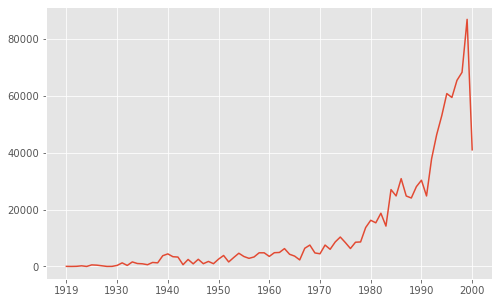

In [18]:
df.year.value_counts().sort_index().plot()
df.groupby('year')[['rating']].agg(['mean', 'count'])

<AxesSubplot:ylabel='genres'>

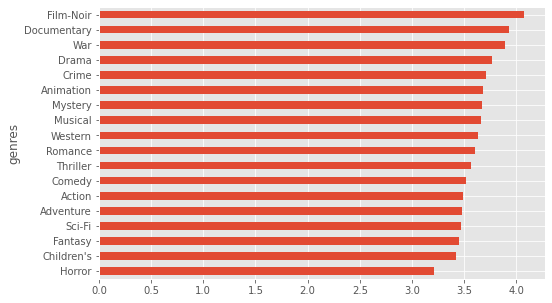

In [19]:
# df.genres
df_exploded = df.assign(genres=df.genres.str.split('|')).explode("genres")
df_exploded.groupby('genres').rating.mean().sort_values().plot.barh()

In [8]:
path = "/Users/whlin/Library/CloudStorage/OneDrive-HKUSTConnect/Documents/python/code_from_others/pydata-book-3rd-edition/datasets/babynames"


In [9]:
names1880 = pd.read_csv(Path(path, 'yob1880.txt'), names=['name', 'sex', 'births'])

In [10]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [39]:
columns = ['name', 'sex', 'births']
pieces = []

df = pd.concat(
    # [pd.read_csv(file, names=columns).assign(year=file.name[3:7]) for file in sorted(Path(path).glob('yob*.txt'))[:50]], ignore_index=True
    [pd.read_csv(file, names=columns).assign(year=file.name[3:7]) for file in sorted(Path(path).glob('yob*.txt'))], ignore_index=True
    )
    

# for file in sorted(Path(path).glob('yob*.txt')):
#     year = file.name[3:7]
#     pieces.append(pd.read_csv(file, names=columns).assign(year=year))
# pd.concat(pieces)

df

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


<AxesSubplot:xlabel='year'>

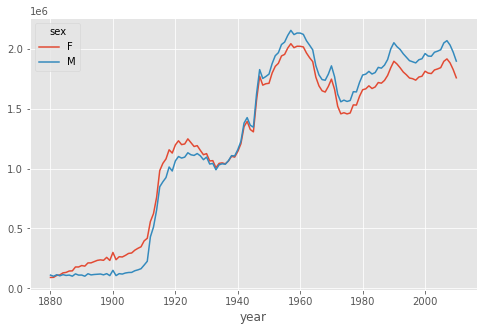

In [40]:
df.groupby(['sex','year']).births.sum().unstack(0).plot()

True

,name,sex,births,year,pct
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1677639,Camilo,M,194,2010,0.000102
1677640,Destin,M,194,2010,0.000102
1677641,Jaquan,M,194,2010,0.000102
1677642,Jaydan,M,194,2010,0.000102


array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>],
      dtype=object)

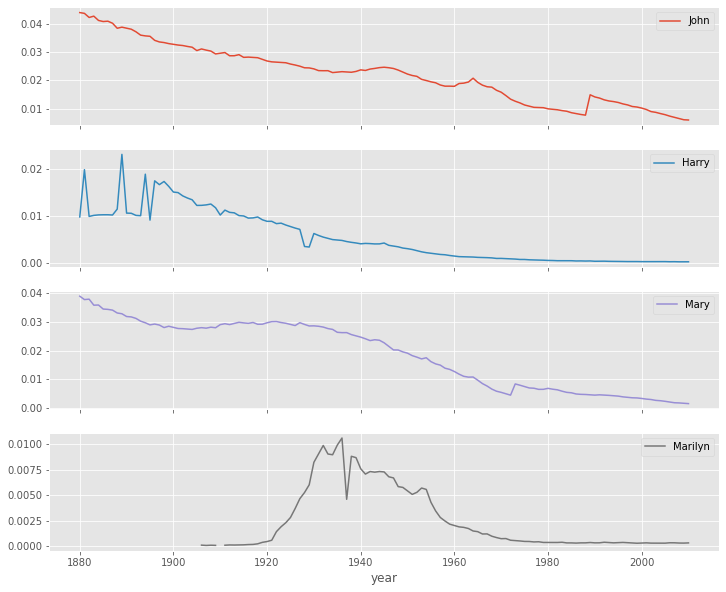

In [59]:
# M1 
# df.groupby(['year','sex']).apply(lambda g: g.assign(pct=g.births/g.births.sum()))

# M2
df = df.assign(pct=df.groupby(['year','sex']).births.transform(lambda s: s/s.sum()))

# sanity 
df.groupby(['year','sex']).pct.sum().eq(1.0).all()


# df.groupby(['year','sex']).

# top_k = df.groupby(['year','sex'], group_keys=False).apply(lambda g: g.nlargest(n=100, columns='pct'))
# top_k = df.groupby(['year','sex'], group_keys=False).apply(lambda g: g.nlargest(n=100, columns='pct'))


# df.nlargest(n=10, columns='births')


# sometimes, better to do subplots..
top_k = df.groupby(['year','sex'], group_keys=False).apply(lambda g: g.nlargest(n=1000, columns='pct'))

top_k
top_k.groupby(['year','name']).pct.mean().unstack(1)[["John", "Harry", "Mary", "Marilyn"]].plot(subplots=True, figsize=(12,10))
top_k.groupby(['year','name']).births.sum().unstack(1)[["John", "Harry", "Mary", "Marilyn"]].plot(subplots=True, figsize=(12,10))

# top_k.groupby(['year','name']).births.sum().unstack(1)[["John", "Harry", "Mary", "Marilyn"]]



In [62]:
# df.groupby('name').births.sum()
df.query("year == '1880' and name =='Mary'")

,index,name,sex,births,year
0,0,Mary,F,7065,1880
1273,1273,Mary,M,27,1880


In [25]:
tips.groupby('sex').tip.nlargest(3)

sex        
Male    170    10.00
        212     9.00
        23      7.58
Female  214     6.50
        52      5.20
        85      5.17
Name: tip, dtype: float64